# Background

Home Credit saat ini sedang menggunakan berbagai macam metode statistik dan machine learning untuk membuat prediksi skor kredit.

## Problem

Home Credit ingin mengoptimalkan proses penyeleksian pelanggan yang mengajukan pinjaman.

## Goal

Memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman.

## Objective

Membuat dan mengevaluasi model machine learning yang dapat memprediksi kemampuan pelanggan untuk melakukan pelunasan.

## Business Metrics

TARGET (parameter kemampuan pelanggan untuk melakukan pelunasan; 0 = mampu, 1 = tidak mampu)

# Import Library

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [77]:
#application dataset

df_app_train = pd.read_csv('application_train.csv')
df_app_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
303714,451887,0,Cash loans,M,N,N,0,157500.0,450000.0,22977.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
111219,229035,0,Cash loans,F,N,Y,1,45000.0,855882.0,43830.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0
307309,456033,0,Cash loans,F,Y,Y,1,117000.0,1089000.0,31842.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
192652,323412,0,Cash loans,F,N,N,0,67500.0,611905.5,34168.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
189661,319907,0,Cash loans,F,N,Y,0,180000.0,1190340.0,66595.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


# EDA

### Distribusi Target Berdasarkan Tipe Kontrak

In [78]:
eda1 = df_app_train.groupby(['NAME_CONTRACT_TYPE','TARGET']).agg({'SK_ID_CURR' : ['count']}).reset_index()
eda1.columns = ['Contract Type','Target','Count']
eda1['%']    = round(eda1['Count'] / eda1.groupby('Contract Type')['Count'].transform('sum')*100,2)

eda1 = pd.pivot_table(eda1, index = 'Contract Type', columns = 'Target', values = '%')

In [79]:
eda1

Target,0,1
Contract Type,,
Cash loans,91.65,8.35
Revolving loans,94.52,5.48


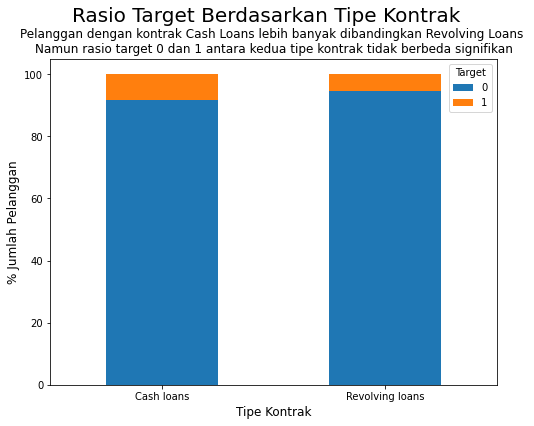

In [80]:
eda1.plot(kind='bar',
          stacked=True, 
          figsize=(8, 6))

plt.suptitle('Rasio Target Berdasarkan Tipe Kontrak', size=20, y=1)
plt.title('Pelanggan dengan kontrak Cash Loans lebih banyak dibandingkan Revolving Loans \n'
          'Namun rasio target 0 dan 1 antara kedua tipe kontrak tidak berbeda signifikan', size=12)

plt.xticks(rotation=0)
plt.xlabel('Tipe Kontrak', size=12)
plt.ylabel('% Jumlah Pelanggan', size=12)

plt.show()

Berdasarkan jumlahnya, pelanggan dengan tipe kontrak Cash loans memiliki jumlah lebih banyak dibandingkan Revolving loans. Lalu jika dilihat dari persentase antara target, perbedaan antara kedua jenis tipe kontrak tidak berbeda signifikan. <br>
Disarankan untuk membuat campaign untuk menambah minat customer terhadap pinjaman revolving loan.

### Kepemilikan Property pada Pelanggan

In [81]:
eda2 = df_app_train.groupby(['FLAG_OWN_CAR','FLAG_OWN_REALTY']).agg({'SK_ID_CURR' : ['count']})

Property = pd.Index(['No Car and Realty','No Car, Have Realty','Have Car, No Realty','Have Car and Realty'])
eda2 = eda2.set_index(Property)

In [82]:
eda2

,SK_ID_CURR
,count
No Car and Realty,61972
"No Car, Have Realty",140952
"Have Car, No Realty",32227
Have Car and Realty,72360


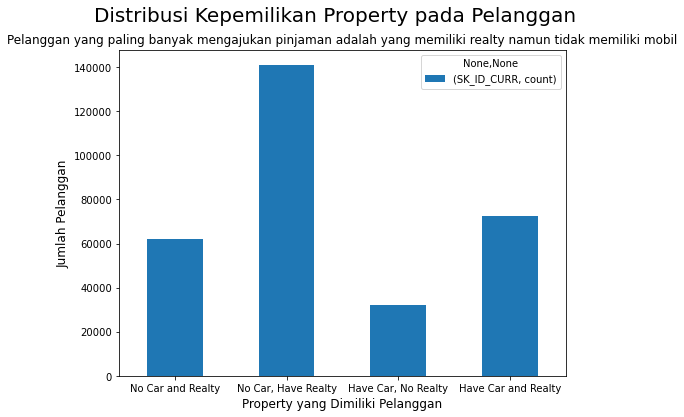

In [83]:
eda2.plot(kind='bar', figsize=(8, 6))

plt.suptitle('Distribusi Kepemilikan Property pada Pelanggan', size=20)
plt.title('Pelanggan yang paling banyak mengajukan pinjaman adalah yang memiliki realty namun tidak memiliki mobil', size=12)

plt.xticks(rotation=0)
plt.xlabel('Property yang Dimiliki Pelanggan', size=12)
plt.ylabel('Jumlah Pelanggan', size=12)

plt.show()

Pelanggan yang paling banyak mengajukan pinjaman adalah yang memiliki realty namun tidak memiliki mobil. Sedangkan yang paling sedikit adalah pelanggan yang punya mobil namun tidak memiliki realty. <br>
Disarankan untuk meningkatkan promosi atau campaign untuk pinjaman kredit mobil untuk meningkatkan minat pelanggan.

### Distribusi Usia Pelanggan

In [84]:
df_app_train['AGE'] = round(abs(df_app_train['DAYS_BIRTH']/(365)),0)

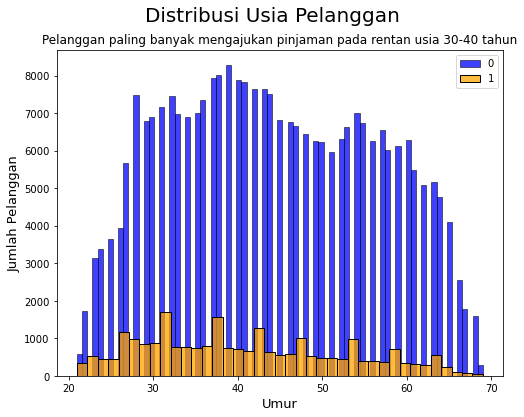

In [85]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_app_train[df_app_train['TARGET']==0]['AGE'], color='blue', ax=ax, label='0')
sns.histplot(df_app_train[df_app_train['TARGET']==1]['AGE'], color='orange', ax=ax, label='1')

plt.suptitle('Distribusi Usia Pelanggan', size=20)
plt.title('Pelanggan paling banyak mengajukan pinjaman pada rentan usia 30-40 tahun', size=12)

plt.xlabel('Umur', fontsize=13)
plt.ylabel('Jumlah Pelanggan', fontsize=13)

plt.legend()
plt.show()

Distribusi usia pelanggan cenderung normal dengan pelanggan paling banyak pada rentan usia 30-40 tahun. <br>
Disarankan untuk meningkatkan campaign untuk pelanggan pada rentan usia tersebut.

# Data Preprocessing

## Null data

In [86]:
df_app_train.shape

(307511, 123)

In [87]:
#Null value pada dataset train

null_value = pd.DataFrame((df_app_train.isnull().sum()/len(df_app_train)*100).sort_values(ascending=False))
pd.set_option('display.max_rows', None)
print(null_value)
pd.reset_option('all')

                                      0
COMMONAREA_MEDI               69.872297
COMMONAREA_MODE               69.872297
COMMONAREA_AVG                69.872297
NONLIVINGAPARTMENTS_MEDI      69.432963
NONLIVINGAPARTMENTS_MODE      69.432963
NONLIVINGAPARTMENTS_AVG       69.432963
FONDKAPREMONT_MODE            68.386172
LIVINGAPARTMENTS_MEDI         68.354953
LIVINGAPARTMENTS_MODE         68.354953
LIVINGAPARTMENTS_AVG          68.354953
FLOORSMIN_MEDI                67.848630
FLOORSMIN_MODE                67.848630
FLOORSMIN_AVG                 67.848630
YEARS_BUILD_AVG               66.497784
YEARS_BUILD_MEDI              66.497784
YEARS_BUILD_MODE              66.497784
OWN_CAR_AGE                   65.990810
LANDAREA_MODE                 59.376738
LANDAREA_AVG                  59.376738
LANDAREA_MEDI                 59.376738
BASEMENTAREA_MODE             58.515956
BASEMENTAREA_MEDI             58.515956
BASEMENTAREA_AVG              58.515956
EXT_SOURCE_1                  56.381073


Kolom dengan nilai null melebihi 30% dihilangkan.

In [88]:
df_app_train = df_app_train.drop(columns = null_value[null_value[0]>30].index)

Untuk kolom dengan nilai null kurang dari 1%, baris dengan nilai null akan dihilangkan

In [89]:
df_app_train = df_app_train.dropna(subset=['NAME_TYPE_SUITE','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE',
                                           'OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','EXT_SOURCE_2',
                                           'AMT_GOODS_PRICE','AMT_ANNUITY','CNT_FAM_MEMBERS','DAYS_LAST_PHONE_CHANGE'])

## Imputation

Data null akan diimputasi dengan nilai median

In [90]:
for i in ['EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_HOUR',
          'AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_DAY']:
    df_app_train[i].fillna(df_app_train[i].median(), inplace=True)

## Duplicate Data

In [91]:
df_app_train.duplicated().sum()

0

Tidak ada baris duplikatv pada dataset

## Feature Engineering

Fitur `AGE` sudah ditambah pada tahap EDA. <br>
Fitur yang tidak relevan / diperlukan akan dihapus.

In [92]:
for i in ['SK_ID_CURR','DAYS_BIRTH','NAME_TYPE_SUITE','EXT_SOURCE_2','EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_DAY',
          'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
          'AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_HOUR','OBS_30_CNT_SOCIAL_CIRCLE',
          'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']:
    df_app_train = df_app_train.drop(columns = i)

## Unsuitable Values

Kesesuaian nilai pada tiap fitur diperiksa.

In [93]:
df_app_train['CODE_GENDER'].value_counts()

F      200482
M      104045
XNA         4
Name: CODE_GENDER, dtype: int64

In [94]:
#XNA diasumsikan M
df_app_train['CODE_GENDER'] = df_app_train['CODE_GENDER'].replace('XNA','M')

In [95]:
print(df_app_train['FLAG_MOBIL'].value_counts())

1    304531
Name: FLAG_MOBIL, dtype: int64


In [96]:
#Fitur hanya punta 1 nilai, sehingga dihilangkan
df_app_train = df_app_train.drop(columns = ['FLAG_MOBIL'])

In [97]:
df_app_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67270
XNA                       54852
Self-employed             38048
Other                     16546
Medicine                  11078
Business Entity Type 2    10458
Government                10308
School                     8823
Trade: type 7              7769
Kindergarten               6823
Construction               6659
Business Entity Type 1     5919
Transport: type 4          5353
Trade: type 3              3443
Industry: type 9           3328
Industry: type 3           3254
Security                   3215
Housing                    2935
Industry: type 11          2685
Military                   2610
Bank                       2455
Agriculture                2436
Police                     2319
Transport: type 2          2184
Postal                     2137
Security Ministries        1953
Trade: type 2              1871
Restaurant                 1794
Services                   1561
University                 1311
Industry: type 7           1295
Transpor

In [98]:
#Fitur terlalu banyak nilai unik dan nilai XNA sangat banyak, sehingga fitur dihapus
df_app_train = df_app_train.drop(columns = ['ORGANIZATION_TYPE'])

In [99]:
df_app_train['NAME_INCOME_TYPE'].value_counts()

Working                 157341
Commercial associate     70794
Pensioner                54841
State servant            21504
Unemployed                  19
Student                     17
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [100]:
#Nilai dengan value counts yang sangat sedikit dihilangkan
for i in ['Unemployed','Student','Businessman','Maternity leave']:
    df_app_train = df_app_train[(df_app_train['NAME_INCOME_TYPE'] != i)]

In [101]:
for i in ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
          'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
          'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
          'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
          'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
          'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
          'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']:
    print(df_app_train[i].value_counts())
    print('----'*10)

0    304467
1        13
Name: FLAG_DOCUMENT_2, dtype: int64
----------------------------------------
1    217076
0     87404
Name: FLAG_DOCUMENT_3, dtype: int64
----------------------------------------
0    304455
1        25
Name: FLAG_DOCUMENT_4, dtype: int64
----------------------------------------
0    300001
1      4479
Name: FLAG_DOCUMENT_5, dtype: int64
----------------------------------------
0    277661
1     26819
Name: FLAG_DOCUMENT_6, dtype: int64
----------------------------------------
0    304441
1        39
Name: FLAG_DOCUMENT_7, dtype: int64
----------------------------------------
0    279612
1     24868
Name: FLAG_DOCUMENT_8, dtype: int64
----------------------------------------
0    303307
1      1173
Name: FLAG_DOCUMENT_9, dtype: int64
----------------------------------------
0    304474
1         6
Name: FLAG_DOCUMENT_10, dtype: int64
----------------------------------------
0    303309
1      1171
Name: FLAG_DOCUMENT_11, dtype: int64
-----------------------------

In [102]:
#Beberapa kolom flag_document memiliki distribusi nilai dengan data minoritas yang sangat sedikit
#Kolom demikian didrop karena imbalance dan tidak berpengaruh besar pada modeling

for i in ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_7','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10',
          'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
          'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']:
    df_app_train = df_app_train.drop(columns = i)

# Statistical Summary

In [103]:
nums = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
        'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
        'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
        'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_LIVE_CITY','FLAG_DOCUMENT_3','FLAG_DOCUMENT_6','FLAG_DOCUMENT_8',
        'CNT_FAM_MEMBERS','HOUR_APPR_PROCESS_START','DAYS_LAST_PHONE_CHANGE','AGE']
       
cats = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_CONTRACT_TYPE','CODE_GENDER','NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START']

In [104]:
df_app_train[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,304480.0,0.417144,0.722313,0.00000,0.000000,0.00000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,304480.0,168652.629629,237867.182010,25650.00000,112500.000000,147600.00000,202500.000000,1.170000e+08
AMT_CREDIT,304480.0,599531.391990,402113.045899,45000.00000,270000.000000,517266.00000,808650.000000,4.050000e+06
AMT_ANNUITY,304480.0,27144.846573,14473.781247,1615.50000,16573.500000,24939.00000,34641.000000,2.580255e+05
AMT_GOODS_PRICE,304480.0,538459.968922,369006.940123,40500.00000,238500.000000,450000.00000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,304480.0,0.020841,0.013806,0.00029,0.010006,0.01885,0.028663,7.250800e-02
DAYS_EMPLOYED,304480.0,63819.409626,141281.274212,-17912.00000,-2762.000000,-1215.00000,-290.000000,3.652430e+05
DAYS_REGISTRATION,304480.0,-4986.739937,3521.673677,-24672.00000,-7479.000000,-4505.00000,-2012.000000,0.000000e+00
DAYS_ID_PUBLISH,304480.0,-2994.739543,1509.389893,-7197.00000,-4299.000000,-3255.00000,-1721.000000,0.000000e+00
FLAG_EMP_PHONE,304480.0,0.819877,0.384291,0.00000,1.000000,1.00000,1.000000,1.000000e+00


In [105]:
df_app_train[cats].describe().T

,count,unique,top,freq
FLAG_OWN_CAR,304480,2,N,200879
FLAG_OWN_REALTY,304480,2,Y,211606
NAME_CONTRACT_TYPE,304480,2,Cash loans,276582
CODE_GENDER,304480,2,F,200452
NAME_INCOME_TYPE,304480,4,Working,157341
NAME_EDUCATION_TYPE,304480,5,Secondary / secondary special,216556
NAME_FAMILY_STATUS,304480,5,Married,194630
NAME_HOUSING_TYPE,304480,6,House / apartment,270202
WEEKDAY_APPR_PROCESS_START,304480,7,TUESDAY,53391


# Correlation

<AxesSubplot:>

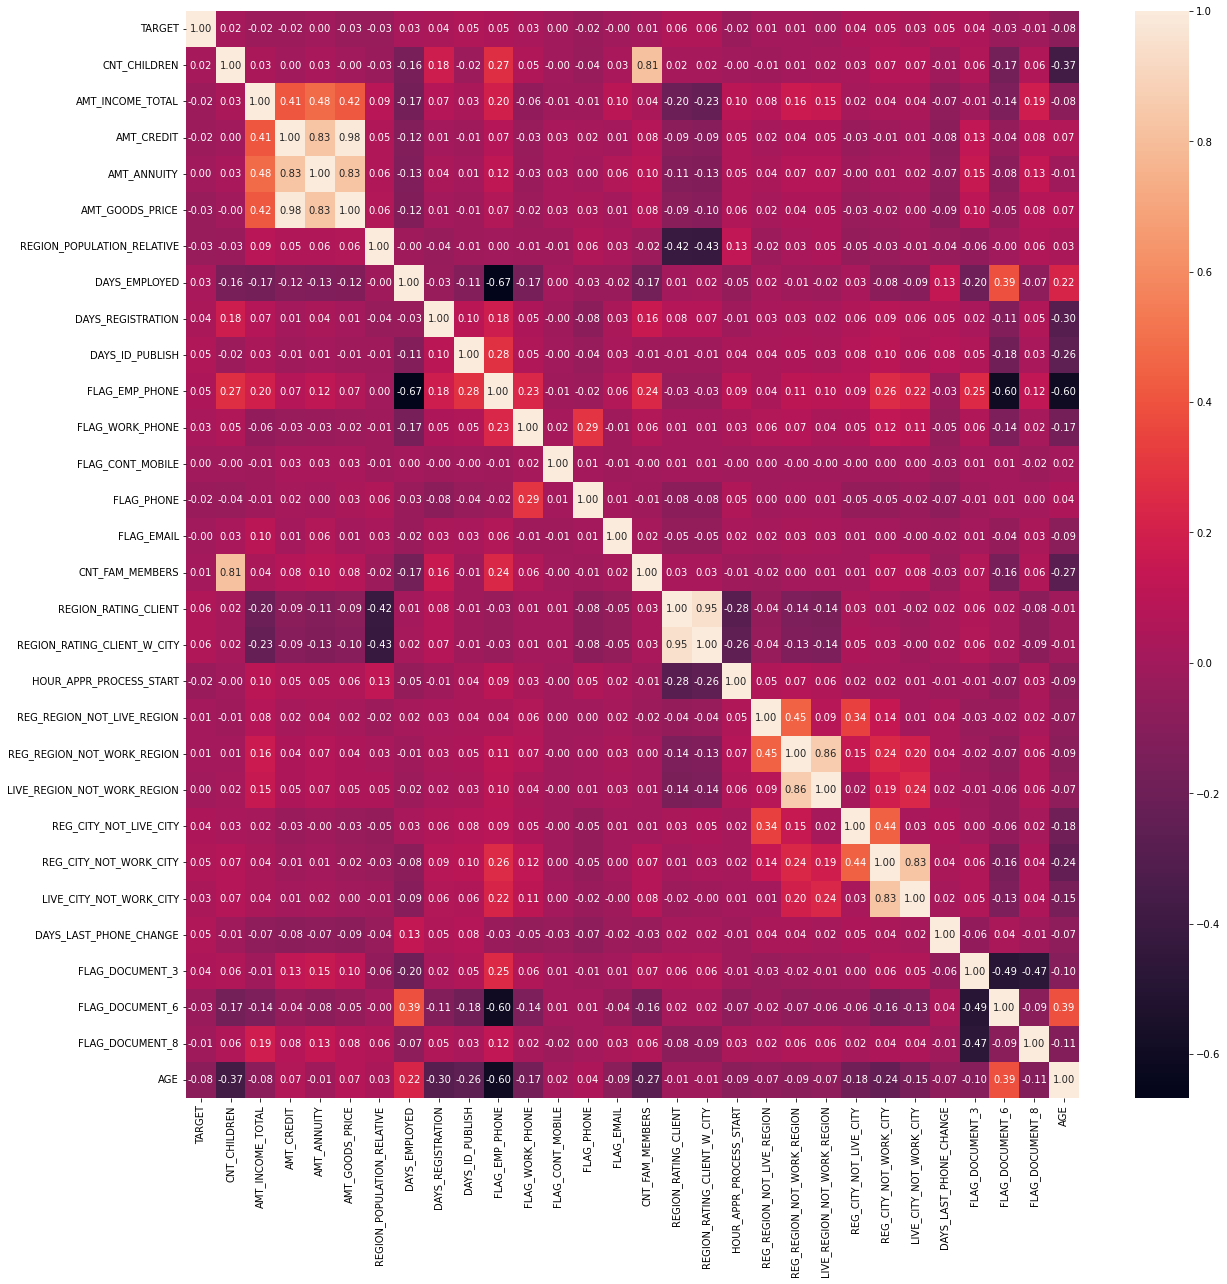

In [106]:
#Dipilih metode spearman karena terdapat outlier pada data dan diasumsikan fitur tidak berhubungan secara linier

r = df_app_train.corr(method='spearman')
plt.figure(figsize=(20,20))
sns.heatmap(r, annot=True, fmt='.2f')

Tidak ada fitur yang berkorelasi kuat dengan TARGET. <br>
Beberapa fitur yang tidak ada korelasi kuat dengan fitur lain didrop.

In [107]:
df_app_train = df_app_train.drop(columns=['FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_EMAIL','DAYS_LAST_PHONE_CHANGE'])

# Feature Encoding

In [108]:
for i in cats:
    print(df_app_train[i].value_counts())
    print('-----'*5)

N    200879
Y    103601
Name: FLAG_OWN_CAR, dtype: int64
-------------------------
Y    211606
N     92874
Name: FLAG_OWN_REALTY, dtype: int64
-------------------------
Cash loans         276582
Revolving loans     27898
Name: NAME_CONTRACT_TYPE, dtype: int64
-------------------------
F    200452
M    104028
Name: CODE_GENDER, dtype: int64
-------------------------
Working                 157341
Commercial associate     70794
Pensioner                54841
State servant            21504
Name: NAME_INCOME_TYPE, dtype: int64
-------------------------
Secondary / secondary special    216556
Higher education                  73800
Incomplete higher                 10171
Lower secondary                    3790
Academic degree                     163
Name: NAME_EDUCATION_TYPE, dtype: int64
-------------------------
Married                 194630
Single / not married     44867
Civil marriage           29475
Separated                19586
Widow                    15922
Name: NAME_FAMILY_STATUS

In [109]:
#Label Encoding
map_car = {'N' : 0,
           'Y' : 1}

map_realty = {'N' : 0,
              'Y' : 1}

map_contract = {'Cash loans' : 0,
                'Revolving loans' : 1}

map_gender = {'M' : 0,
              'F' : 1}

map_education = {'Lower secondary'               : 0,
                 'Secondary / secondary special' : 1,
                 'Incomplete higher'             : 2,
                 'Higher education'              : 3,
                 'Academic degree'               : 4}  

df_app_train['FLAG_OWN_CAR']        = df_app_train['FLAG_OWN_CAR'].map(map_car)
df_app_train['FLAG_OWN_REALTY']     = df_app_train['FLAG_OWN_REALTY'].map(map_realty)
df_app_train['NAME_CONTRACT_TYPE']  = df_app_train['NAME_CONTRACT_TYPE'].map(map_contract)
df_app_train['CODE_GENDER']         = df_app_train['CODE_GENDER'].map(map_gender)
df_app_train['NAME_EDUCATION_TYPE'] = df_app_train['NAME_EDUCATION_TYPE'].map(map_education)

In [110]:
#One hot encoding

for i in ['NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START']:
    ohe = pd.get_dummies(df_app_train[i], prefix=i)
    df_app_train = df_app_train.join(ohe)
    df_app_train = df_app_train.drop(columns=i)

# Feature Standardization

In [111]:
from sklearn.preprocessing import StandardScaler

In [112]:
for i in ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
          'REGION_POPULATION_RELATIVE','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH',
          'CNT_FAM_MEMBERS','HOUR_APPR_PROCESS_START','AGE']:
    df_app_train[i] = df_app_train[i].astype(str).astype(float)
    df_app_train[i] = StandardScaler().fit_transform(df_app_train[i].values.reshape(len(df_app_train),1))

In [113]:
df_app_train.sample(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
133470,1,0,0,1,1,-0.577512,-0.236068,-0.857550,-0.690584,-0.849470,...,0,0,1,0,0,0,0,0,0,1
11076,0,0,1,1,1,-0.577512,0.615249,-0.135513,0.585380,-0.239725,...,0,0,0,0,0,0,0,1,0,0
85410,0,0,1,0,1,-0.577512,0.236886,0.453576,1.350524,0.370021,...,0,0,0,0,1,0,0,0,0,0
175411,1,0,1,0,1,-0.577512,0.709840,0.852420,0.036940,0.370021,...,0,0,0,0,0,0,0,0,0,1
56938,0,0,1,0,0,0.806931,-0.273904,-0.995690,-1.164096,-1.093369,...,1,0,0,0,0,0,0,0,1,0


# Class Imbalance

In [114]:
x_std = df_app_train.drop(columns = 'TARGET')
y_std = df_app_train['TARGET']

In [115]:
y_std.value_counts()

0    279823
1     24657
Name: TARGET, dtype: int64

Data imbalance karena nilai minoritas hanya 8% dari dataset. <br>
Dilakukan undersampling

In [116]:
from imblearn import under_sampling

x_under, y_under = under_sampling.RandomUnderSampler().fit_resample(x_std, y_std)

In [117]:
y_under.value_counts()

0    24657
1    24657
Name: TARGET, dtype: int64

# Train Test Split

In [118]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_under, y_under)

# Model Training

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [120]:
def score_compare(x_train,x_test,y_train,y_test):
    result = defaultdict(list)
    
    knn = KNeighborsClassifier()
    logreg = LogisticRegression()
    dtc = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    
    list_model = [('K-Nearest Neighbor',knn),
                  ('Logistic Regression',logreg),
                  ('Decision Tree',dtc),
                  ('Random Forest',rf)
                 ]
    
    for model_name,model in list_model:
        model.fit(x_train,y_train)
        
        y_pred = model.predict(x_test)
        
        accuracy = accuracy_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        precision = precision_score(y_test,y_pred)
        
        result['model_name'].append(model_name)
        result['accuracy'].append(accuracy)
        result['recall'].append(recall)
        result['precision'].append(precision)
        
    return result

In [121]:
result = score_compare(x_train,x_test,y_train,y_test)
result = pd.DataFrame(result)

In [122]:
result

,model_name,accuracy,recall,precision
0,K-Nearest Neighbor,0.558196,0.572605,0.558620
1,Logistic Regression,0.617001,0.617025,0.619024
2,Decision Tree,0.551545,0.555484,0.553250
3,Random Forest,0.618947,0.596673,0.626633


Secara overall, model logistic regression memiliki performa terbaik. Dilakukan hyperparameter tuning pada model ini.

# Tuning

In [123]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 0.1, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression()
rs = RandomizedSearchCV(logreg, hyperparameters, cv=5)
rs.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': [0.0001, 0.0011090909090909092,
                                              0.002118181818181818,
                                              0.0031272727272727272,
                                              0.004136363636363637,
                                              0.005145454545454546,
                                              0.006154545454545455,
                                              0.007163636363636364,
                                              0.008172727272727272,
                                              0.009181818181818182,
                                              0.01019090909090909, 0.0112,
                                              0.012209090909090909,
                                              0.013218181818181818,
                                              0.014227272727272727,
                                          

In [124]:
y_pred_hyp = rs.predict(x_test)

In [125]:
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred_hyp))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred_hyp))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred_hyp))

Accuracy (Test Set): 0.62
Precision (Test Set): 0.62
Recall (Test Set): 0.62


Hasil setelah tuning meningkat tidak signifikan.

# Evaluasi

## ROC Curve

In [126]:
y_pred_proba = rs.predict_proba(x_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score

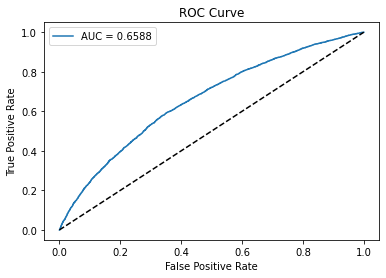

In [128]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

## Kolmogorov-Smirnov

In [129]:
df_actual_predicted = df_actual_predicted.sort_values('y_pred_proba')
df_actual_predicted = df_actual_predicted.reset_index()

df_actual_predicted['Cumulative N Population'] = df_actual_predicted.index + 1
df_actual_predicted['Cumulative N Bad'] = df_actual_predicted['y_actual'].cumsum()
df_actual_predicted['Cumulative N Good'] = df_actual_predicted['Cumulative N Population'] - df_actual_predicted['Cumulative N Bad']
df_actual_predicted['Cumulative Perc Population'] = df_actual_predicted['Cumulative N Population'] / df_actual_predicted.shape[0]
df_actual_predicted['Cumulative Perc Bad'] = df_actual_predicted['Cumulative N Bad'] / df_actual_predicted['y_actual'].sum()
df_actual_predicted['Cumulative Perc Good'] = df_actual_predicted['Cumulative N Good'] / (df_actual_predicted.shape[0] - df_actual_predicted['y_actual'].sum())
df_actual_predicted.head()

,index,y_actual,y_pred_proba,Cumulative N Population,Cumulative N Bad,Cumulative N Good,Cumulative Perc Population,Cumulative Perc Bad,Cumulative Perc Good
0,4923,0,0.102696,1,0,1,0.000081,0.000000,0.000163
1,16879,0,0.108925,2,0,2,0.000162,0.000000,0.000326
2,11373,0,0.110552,3,0,3,0.000243,0.000000,0.000489
3,32382,1,0.115593,4,1,3,0.000324,0.000162,0.000489
4,3865,0,0.120615,5,1,4,0.000406,0.000162,0.000652


Text(0.5, 1.0, 'Kolmogorov-Smirnov:  0.2411')

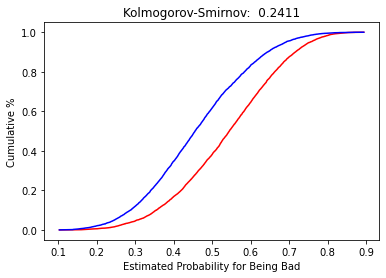

In [130]:
KS = max(df_actual_predicted['Cumulative Perc Good'] - df_actual_predicted['Cumulative Perc Bad'])

plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Bad'], color='r')
plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Good'], color='b')
plt.xlabel('Estimated Probability for Being Bad')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov:  %0.4f' %KS)